# Eductational Process Mining Dataset 

## Dataset Characteristics

**Has GROUPING field**

**Evaluation Metrics after Feature Engineering**

**I. Learning activity level**:

- Correct learning activity: available

- Number of hints per learning activity: available

- Number of attempts per learning activity: available

- Score per learning activity: not available

**II. Group level**:

**III. Course level**:

- Intermediate grades: not available

- Final grade: not available

**Dataset Remarks**

*  [Link](http://www.esng.dibe.unige.it/deeds/LearningMaterials/IndexByTopic.htm) contains the content for the different exercise codes

* There are assessments available for each session (grouping variable) and the whole course (i.e. final exam grades) -> the final exam is itself structured into questions belonging to one of the sessions

* The first session has no intermediate grades -> maybe do not include it?

* After filtering out consecutive learning resources of the same type, there are not many interactions left.

## Preliminaries

### Constants

In [1]:
# paths
PATH_TO_INTERACTION_DATA_FOLDER = '../../../../../data/EPMDataset/EPM Dataset 2/Data/Processes'
PATH_TO_FEATURE_NAME_DATA = '../../../../../data/EPMDataset/EPM Dataset 2/features.txt' 
PATH_TO_INTERMEDIATE_GRADES_DATA_FOLDER = '../../../../../data/EPMDataset/EPM Dataset 2/Data/intermediate_grades.xlsx'
PATH_TO_FINAL_GRADES_DATA_FOLDER = '../../../../../data/EPMDataset/EPM Dataset 2/Data/final_grades.xlsx'

# dataset name
DATASET_NAME = 'educational_process_mining'

# fields used in the analysis
USER_FIELD = 'student_Id'
GROUP_FIELD = 'session'
LEARNING_ACTIVITY_FIELD = 'exercise'
TIMESTAMP_FIELD = 'start_time'

# fields used in dataset preparation
ACTIVITY_FIELD = 'activity'
USER_FIELD_INTERMEDIATE_GRADES = 'Student Id'
USER_FIELD_FINAL_GRADES = 'Student ID'

# strings and values used in dataset preparation
ACTIVITY_STUDY_STR = 'Study' # only used when activities are filtered for study interacions
ACTIVITY_DEEDS_EXERCISE_STR = 'Deeds_Es_' # only used when activities are filtered for exercise interactions
LEARNING_ACTIVITY_IDENTIFIED_EXERCISE_STR = 'Es_'

# evaluation fields
# learning activity level
# group level
EVALUATION_GROUP_SCORE_FIELD = 'score'
# course level
EVALUATION_COURSE_SCORE_FIELD = 'TOTAL\n(100 points)'

### Import Packages

In [2]:
from utilities.sequence_similarity import *
from utilities.sequence_similarity_no_group import *
from utilities.functions import *
from utilities.constants import *

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import textdistance as td
import pickle

### Seaborn Configuration

In [3]:
sns.set(rc = {'figure.figsize':(15,8)})

In [4]:
#sns.set_context("notebook", rc={"font.size":20,"axes.titlesize":30,"axes.labelsize":20, "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":20, "legend.title_fontsize":20})   

In [5]:
sns.set_style("darkgrid")

In [6]:
marker_config = {"marker":"o",
                 "markerfacecolor":"white", 
                 "markeredgecolor":"black",
                 "markersize":"10"}

### Import Pickled Objects

In [7]:
# with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME, 'rb') as f:
#     seq_dist_per_group_dict = pickle.load(f)

# with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PICKLE_NAME, 'rb') as f:
#     seq_dist_dict = pickle.load(f)

## Functions

In [8]:
def import_interaction_data(path_to_data_folder: str, feature_list: list):
    """Imports the epm interaction data

    Parameters
    ----------
    path_to_data_folder : str
        The path to the interactions data folder
    feature_list: list
        A list containing column name strings for the interaction data

    Returns
    -------
    pd.Dataframe
        The epm interactions dataframe
    """
    dataframe_list = []

    for path, subdirs, files in os.walk(path_to_data_folder):
        for name in files:
            filepath = os.path.join(path, name)
            data = pd.read_csv(filepath, header=None)
            dataframe_list.append(data)

    interactions = pd.concat(dataframe_list, ignore_index=True)
    interactions.columns = feature_list

    return interactions


def add_evaluation_fields(interactions: pd.DataFrame,
                          group_field: str,
                          user_field: str,
                          learning_activity_field: str,
                          timestamp_field: str,
                          evaluation_interactions_total_field_name_str: str,
                          evaluation_group_interactions_total_field_name_str: str):
    """Calculates and adds evaluation metrics to the interaction dataframe

    Parameters
    ----------
    interactions : pd.DataFrame
        The interactins dataframe
    group_field : str
        The group field column
    user_field : str
        The user field column
    learning_activity_field : str
        The learning activity field column
    timestamp_field : str
        The timestamp field column
    evaluation_interactions_total_field_name_str : str
        The evaluation total interactions field name
    evaluation_group_interactions_total_field_name_str : str
        The evaluation group total interactions field name

    Returns
    -------
    pd.DataFrame
        The interactions dataframe with added evaluation metrics
    """    
    interactions.sort_values(by=[group_field, user_field, timestamp_field], inplace=True)

    learning_activities = interactions[learning_activity_field].to_list()

    code_list = []
    last_learning_activity = None
    code = 0

    for learning_activity in learning_activities:

        if learning_activity != last_learning_activity:
            code += 1
            code_list.append(code)
            last_learning_activity=learning_activity
        else:
            code_list.append(code)
    
    learning_activity_code_field = 'la_code_for_grouping'
    interactions[learning_activity_code_field] = code_list

    group_data = []
    user_data = []
    learning_activity_data = []
    learning_activity_code_data = []
    number_interactions_total_data = []

    for (group, user, learning_activity, learning_activity_code), df in interactions.groupby([group_field, user_field, learning_activity_field, learning_activity_code_field]):

        df = df.reset_index(drop=True)

        # interactions (all possible interactions)
        number_interactions_total = df.shape[0]

        # attempts

        # hints
        
        # scores

        # corrects

        group_data.append(group)
        user_data.append(user)
        learning_activity_data.append(learning_activity)
        learning_activity_code_data.append(learning_activity_code)
        number_interactions_total_data.append(number_interactions_total)

    evaluation_df = pd.DataFrame({group_field: group_data,
                                  user_field: user_data,
                                  learning_activity_field: learning_activity_data,
                                  learning_activity_code_field: learning_activity_code_data,
                                  evaluation_interactions_total_field_name_str: number_interactions_total_data})

    evaluation_df.replace({False: 0, True: 1}, inplace=True)

    interactions = interactions.merge(evaluation_df, how='left', on=[group_field, user_field, learning_activity_field, learning_activity_code_field])

    return interactions

In [11]:
interactions

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke
0,1,1,Es,Other,2014-02-10 11:25:33,2.10.2014 11:25:34,0,0,0,0,0,84,0
1,1,1,Es,Aulaweb,2014-02-10 11:25:35,2.10.2014 11:25:42,218,0,0,4,0,397,0
2,1,1,Es,Blank,2014-02-10 11:25:43,2.10.2014 11:25:43,0,0,0,0,0,59,0
3,1,1,Es,Deeds,2014-02-10 11:25:44,2.10.2014 11:26:17,154117,6,0,8,0,1581,4
4,1,1,Es,Other,2014-02-10 11:26:18,2.10.2014 11:26:18,0,0,0,2,0,103,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230313,6,99,Es_6_3,Aulaweb,2014-11-12 13:47:30,11.12.2014 13:47:35,60,30,0,1,0,250,0
230314,6,99,Es_6_3,Other,2014-11-12 13:47:36,11.12.2014 13:47:36,0,0,0,3,0,37,0
230315,6,99,Es_6_3,Other,2014-11-12 13:47:37,11.12.2014 13:47:39,64,0,0,2,2,283,0
230316,6,99,Es_6_3,FSM_Es_6_3,2014-11-12 13:47:40,11.12.2014 13:47:40,0,0,0,2,0,67,0


## Dataset Preparation

### Import Data

In [9]:
feature_names = pd.read_csv(PATH_TO_FEATURE_NAME_DATA, sep=" ", header=None)
feature_names = feature_names[1].values
interactions =  import_interaction_data(PATH_TO_INTERACTION_DATA_FOLDER, feature_names)
intermediate_grades = pd.read_excel(PATH_TO_INTERMEDIATE_GRADES_DATA_FOLDER)
final_grades_first = pd.read_excel(PATH_TO_FINAL_GRADES_DATA_FOLDER, sheet_name=0)
final_grades_second = pd.read_excel(PATH_TO_FINAL_GRADES_DATA_FOLDER, sheet_name=1)

c:\Users\sschmerda\Anaconda3\envs\DDIA\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
interactions[TIMESTAMP_FIELD] = pd.to_datetime(interactions[TIMESTAMP_FIELD], errors='coerce')

### Merge and Filter Data

In [11]:
# add intermediate grades to interactions
intermediate_grades_long = intermediate_grades.melt(id_vars=[USER_FIELD_INTERMEDIATE_GRADES], var_name=GROUP_FIELD, value_name=EVALUATION_GROUP_SCORE_FIELD)
intermediate_grades_long[GROUP_FIELD] = intermediate_grades_long[GROUP_FIELD].apply(lambda x: int(x[-1]))
intermediate_grades_long.columns = [USER_FIELD, GROUP_FIELD, EVALUATION_GROUP_SCORE_FIELD]
interactions = interactions.merge(intermediate_grades_long, on=[GROUP_FIELD, USER_FIELD], how='left') 

In [12]:
# add final grades to interactions
final_grades = pd.concat([final_grades_first, final_grades_second], ignore_index=True)
final_grades = final_grades.rename(columns={USER_FIELD_FINAL_GRADES: USER_FIELD})
# use the better grade of one in two possible final exams
index_highest_final_grade = final_grades.groupby(USER_FIELD)[EVALUATION_COURSE_SCORE_FIELD].idxmax() 
final_grades = final_grades.loc[index_highest_final_grade, [USER_FIELD, EVALUATION_COURSE_SCORE_FIELD]]
interactions = interactions.merge(final_grades, on=USER_FIELD, how='left') 

In [13]:
# select only interaction which resulted from studying for or working on a particular exercise
#interactions = interactions.loc[(interactions[ACTIVITY_FIELD].apply(lambda x: x.strip().startswith(ACTIVITY_STUDY_STR))) | (interactions[ACTIVITY_FIELD].apply(lambda x: x.strip().startswith(ACTIVITY_DEEDS_EXERCISE_STR))), :]
# use only exercises which are already started by the respective student and therefore can be clearly identified
interactions = interactions.loc[interactions[LEARNING_ACTIVITY_FIELD].apply(lambda x: x.strip().startswith(LEARNING_ACTIVITY_IDENTIFIED_EXERCISE_STR))]

### Filter Sequences by NAs in Dataset 

In [14]:
pct_na = get_nas_in_data(interactions)
pct_na

session                               0.0 %
student_Id                            0.0 %
exercise                              0.0 %
activity                              0.0 %
start_time                            0.0 %
end_time                              0.0 %
idle_time                             0.0 %
mouse_wheel                           0.0 %
mouse_wheel_click                     0.0 %
mouse_click_left                      0.0 %
mouse_click_right                     0.0 %
mouse_movement                        0.0 %
keystroke                             0.0 %
score                  14.696256858326414 %
TOTAL\n(100 points)     9.071660450793567 %
dtype: object

In [15]:
interactions = drop_learning_activity_sequence_if_contains_na_in_field(interactions, 
                                                                       GROUP_FIELD, 
                                                                       USER_FIELD, 
                                                                       field_list=[GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD, EVALUATION_GROUP_SCORE_FIELD, EVALUATION_COURSE_SCORE_FIELD], 
                                                                       field_value_tuple_filter_list=[])

Input length: 227643
Outpunt length: 179467
Number of rows removed: 48176
Percentage of rows removed: 21%
--------------------------------------------------
Input number of sequences: 520
Output number of sequences: 402
Number of sequences removed: 118
Percentage of sequences removed: 23%


In [16]:
pct_na = get_nas_in_data(interactions)
pct_na

session                0.0 %
student_Id             0.0 %
exercise               0.0 %
activity               0.0 %
start_time             0.0 %
end_time               0.0 %
idle_time              0.0 %
mouse_wheel            0.0 %
mouse_wheel_click      0.0 %
mouse_click_left       0.0 %
mouse_click_right      0.0 %
mouse_movement         0.0 %
keystroke              0.0 %
score                  0.0 %
TOTAL\n(100 points)    0.0 %
dtype: object

### Sort by Timestamp

In [17]:
interactions = sort_by_timestamp(interactions, TIMESTAMP_FIELD, higher_level_sort_list=[GROUP_FIELD, USER_FIELD])

### Transform Data

In [18]:
interactions = add_evaluation_fields(interactions, 
                                     GROUP_FIELD, 
                                     USER_FIELD, 
                                     LEARNING_ACTIVITY_FIELD, 
                                     TIMESTAMP_FIELD, 
                                     EVALUATION_LEARNING_ACTIVITY_INTERACTIONS_TOTAL_FIELD_NAME_STR,
                                     EVALUATION_GROUP_INTERACTIONS_TOTAL_FIELD_NAME_STR)

In [19]:
interactions

,session,student_Id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,mouse_click_left,mouse_click_right,mouse_movement,keystroke,score,TOTAL\n(100 points),la_code_for_grouping,Learning Resource Interactions Total,Topic Interactions Total
0,2,1,Es_2_1,Study_Es_2_1,2014-10-16 11:25:10,16.10.2014 11:25:11,62,0,0,2,0,176,0,5.00,94.5,1,94,77.870259
1,2,1,Es_2_1,Deeds_Es_2_1,2014-10-16 11:25:12,16.10.2014 11:25:15,344,0,0,4,0,276,0,5.00,94.5,1,94,77.870259
2,2,1,Es_2_1,Study_Es_2_1,2014-10-16 11:25:16,16.10.2014 11:25:47,143691,7,0,2,0,898,0,5.00,94.5,1,94,77.870259
3,2,1,Es_2_1,TextEditor_Es_2_1,2014-10-16 11:25:49,16.10.2014 11:25:54,127,0,0,5,0,472,0,5.00,94.5,1,94,77.870259
4,2,1,Es_2_1,Deeds_Es_2_1,2014-10-16 11:25:55,16.10.2014 11:26:1,545,0,0,7,0,363,8,5.00,94.5,1,94,77.870259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179462,6,104,Es_6_3,Properties,2014-11-12 13:44:59,11.12.2014 13:45:3,469,0,0,5,0,150,0,2.75,92.0,6438,5,91.867196
179463,6,104,Es_6_3,Aulaweb,2014-11-12 13:45:04,11.12.2014 13:45:7,30,0,0,3,0,116,0,2.75,92.0,6438,5,91.867196
179464,6,104,Es_6_3,Other,2014-11-12 13:45:08,11.12.2014 13:45:8,0,0,0,0,0,14,0,2.75,92.0,6438,5,91.867196
179465,6,104,Es_6_6,Study_Es_6_6,2014-11-12 13:45:09,11.12.2014 13:46:1,274304,2,0,2,0,2446,0,2.75,92.0,6439,2,91.867196


In [ ]:
interactions.groupby[GROUP_FIELD, USER_FIELD,]

In [19]:
interactions = keep_last_repeated_learning_activities(interactions, GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD)

100%|██████████| 402/402 [00:00<00:00, 3163.99it/s]

Initial number of interactions: 179467
Final number of interactions: 6474
Removed number of interactions: 172993
Removed percentage of interactions: 96.39265157382695%


### Check Dataset

In [ ]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794 entries, 0 to 2389
Data columns (total 22 columns):
 #   Column                                                    Non-Null Count  Dtype         
---  ------                                                    --------------  -----         
 0   EventType                                                 794 non-null    object        
 1   EventID                                                   794 non-null    object        
 2   Order                                                     794 non-null    int64         
 3   SubjectID                                                 794 non-null    object        
 4   ToolInstances                                             794 non-null    object        
 5   CodeStateID                                               794 non-null    int64         
 6   ServerTimestamp                                           794 non-null    datetime64[ns]
 7   ProblemID                                  

In [ ]:
pct_na = get_nas_in_data(interactions)
pct_na

EventType                                                   0.0 %
EventID                                                     0.0 %
Order                                                       0.0 %
SubjectID                                                   0.0 %
ToolInstances                                               0.0 %
CodeStateID                                                 0.0 %
ServerTimestamp                                             0.0 %
ProblemID                                                   0.0 %
Correct                                                     0.0 %
la_code_for_grouping                                        0.0 %
Learning Resource Interactions Total                        0.0 %
Learning Resource Attempts Total                            0.0 %
Learning Resource Hints Total                               0.0 %
Learning Resource Is Correct                                0.0 %
Learning Resource Is Correct Without Hints                  0.0 %
Learning R

### Save the Dataset and Mapping Information 

In [ ]:
save_interaction_and_mapping_df(interactions,
                                PATH_TO_CLEANED_DATASETS,
                                DATASET_NAME,
                                MAPPING_DATAFRAME_NAME_STR,
                                NEW_FIELDNAME_FIELD_NAME_STR,
                                ORIGINAL_FIELDNAME_FIELD_NAME_STR,
                                fields_to_keep_list=[TIMESTAMP_FIELD, 
                                                     ORDER_FIELD, 
                                                     USER_FIELD, 
                                                     LEARNING_ACTIVITY_FIELD, 
                                                     EVALUATION_LEARNING_ACTIVITY_INTERACTIONS_TOTAL_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_ATTEMPTS_TOTAL_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_HINTS_TOTAL_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_WITHOUT_HINTS_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIRST_ATTEMPT_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_FIRST_ATTEMPT_WITHOUT_HINTS_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_LAST_ATTEMPT_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_IS_CORRECT_LAST_ATTEMPT_WITHOUT_HINTS_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_INTERACTIONS_UNTIL_CORRECT_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_ATTEMPTS_UNTIL_CORRECT_FIELD_NAME_STR,
                                                     EVALUATION_LEARNING_ACTIVITY_HINTS_UNTIL_CORRECT_FIELD_NAME_STR],
                                field_name_remapping_dict={TIMESTAMP_FIELD: TIMESTAMP_FIELD_NAME_STR,
                                                           ORDER_FIELD: ORDER_FIELD_NAME_STR,
                                                           USER_FIELD: USER_FIELD_NAME_STR,
                                                           LEARNING_ACTIVITY_FIELD: LEARNING_ACTIVITY_FIELD_NAME_STR})

## Summary Statistics and Plots 

In [18]:
print_summary_stats(interactions, USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, USER_FIELD_NAME_STR, GROUP_FIELD_NAME_STR, LEARNING_ACTIVITY_FIELD_NAME_STR, has_group_field=True)

number of interactions: 9079
number of unique Topics: 6
number of unique Users: 115
number of unique Learning Resources: 30


### Dataset Specific Characteristics

### Interactions per User

In [19]:
interactions_per_user = print_and_return_interactions_per_user(interactions, USER_FIELD, USER_FIELD_NAME_STR)

mean number of interactions per User: 78.94782608695652
median number of interactions per User: 70.0
max number of interactions per User: 287
min number of interactions per User: 6


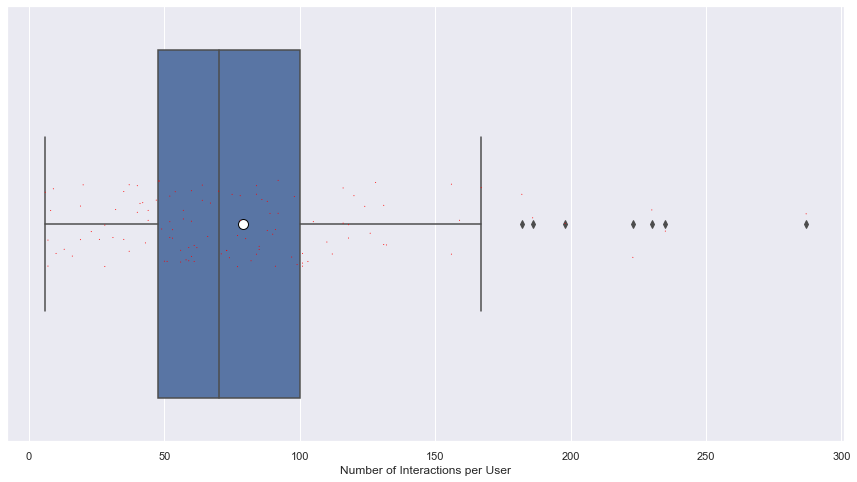

In [20]:
g = sns.boxplot(data=interactions_per_user, x='number of interactions', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=interactions_per_user, x='number of interactions', size=1, color="red");
g.set(xlabel='Number of Interactions per User');

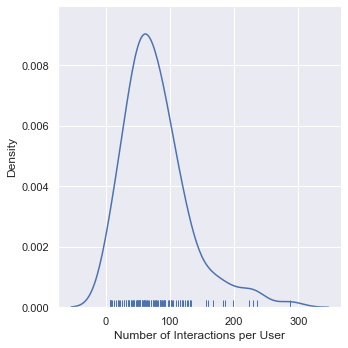

In [21]:
g = sns.displot(data=interactions_per_user, x='number of interactions', log_scale=False, kind='kde', rug=True)
g.set(xlabel='Number of Interactions per User');

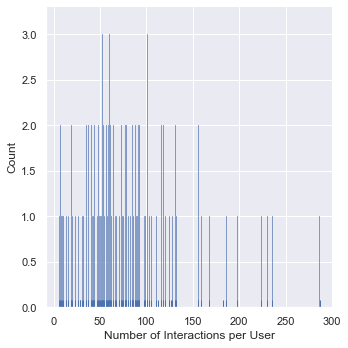

In [22]:
g = sns.displot(data=interactions_per_user, x='number of interactions', log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel='Number of Interactions per User');

### Number of Unique Groups per User

In [23]:
n_unique_groups_per_user = print_and_return_unique_col2_per_col1(interactions, USER_FIELD, GROUP_FIELD, NUMBER_UNIQUE_GROUPS_PER_USER_STR)

mean Number of Unique Topics per User: 4.521739130434782
median Number of Unique Topics per User: 5.0
max Number of Unique Topics per User: 6
min Number of Unique Topics per User: 1


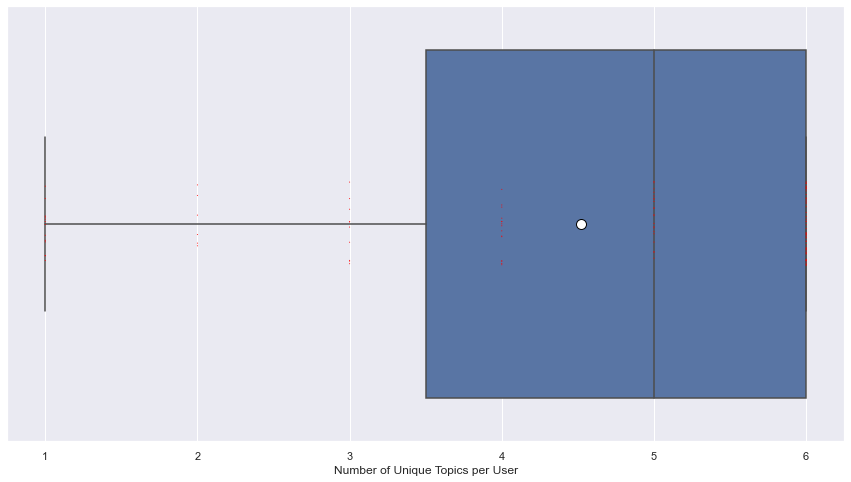

In [24]:
g = sns.boxplot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

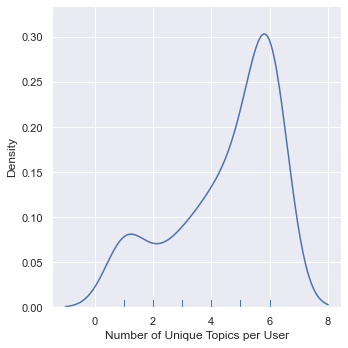

In [25]:
g = sns.displot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

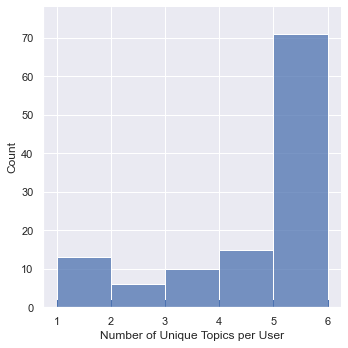

In [26]:
g = sns.displot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

### Number of Unique Learning Activities per User

In [27]:
n_unique_learning_activities_per_user = print_and_return_unique_col2_per_col1(interactions, USER_FIELD, LEARNING_ACTIVITY_FIELD, NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR)

mean Number of Unique Learnig Resources per User: 20.643478260869564
median Number of Unique Learnig Resources per User: 23.0
max Number of Unique Learnig Resources per User: 30
min Number of Unique Learnig Resources per User: 5


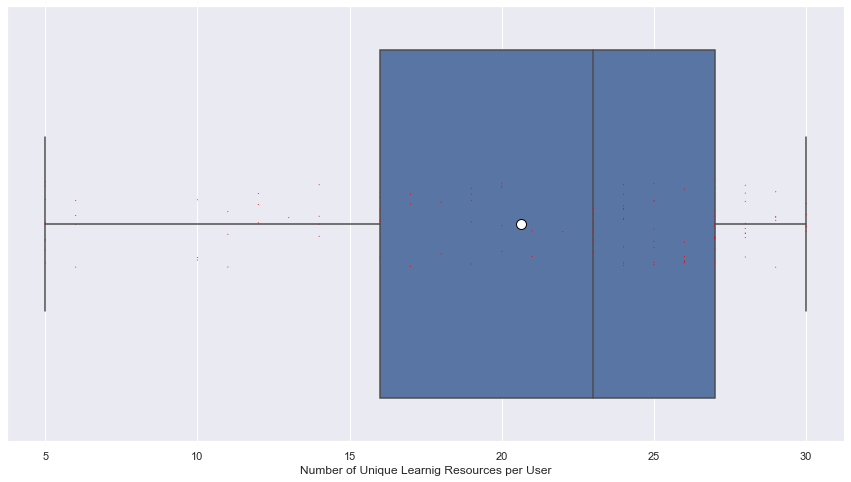

In [28]:
g = sns.boxplot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

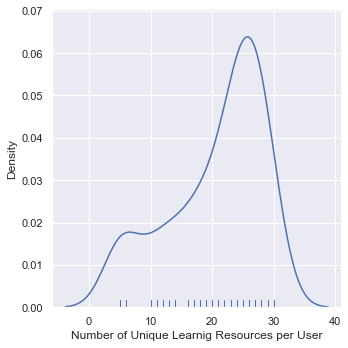

In [29]:
g = sns.displot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

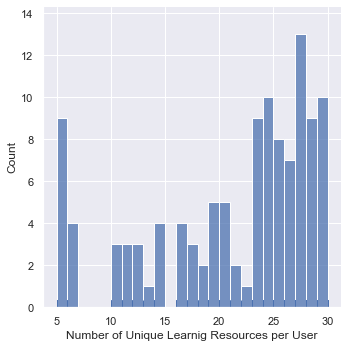

In [30]:
g = sns.displot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

### Number of Unique Users per Group

In [31]:
n_unique_users_per_group = print_and_return_unique_col2_per_col1(interactions, GROUP_FIELD, USER_FIELD, NUMBER_UNIQUE_USERS_PER_GROUP_STR)

mean Number of Unique Users per Topic: 86.66666666666667
median Number of Unique Users per Topic: 85.5
max Number of Unique Users per Topic: 99
min Number of Unique Users per Topic: 77


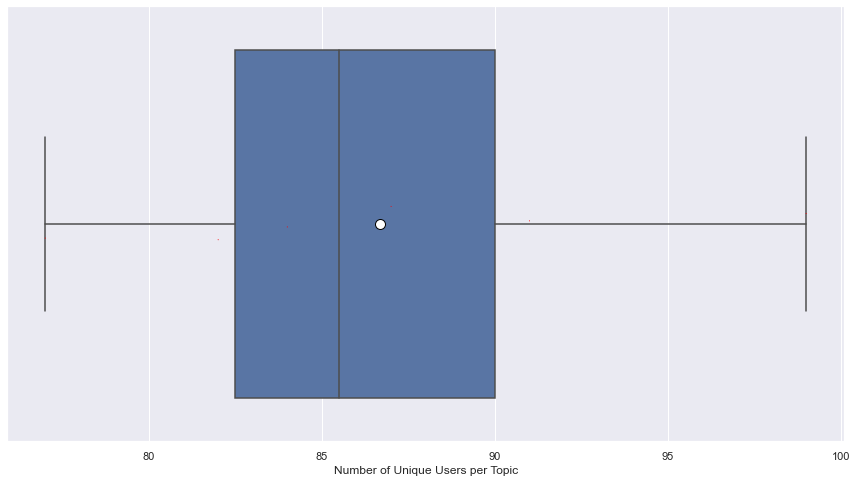

In [32]:
g = sns.boxplot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

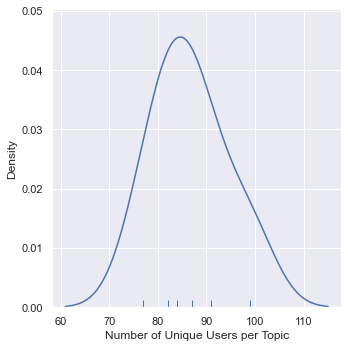

In [33]:
g = sns.displot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

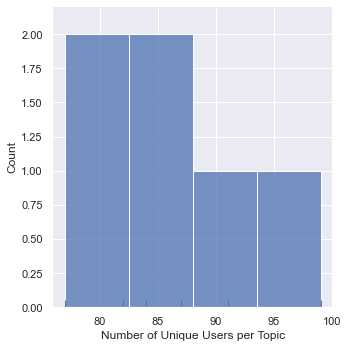

In [34]:
g = sns.displot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

### Number of Unique Learning Activities per Group

In [35]:
n_unique_learning_activities_per_group = print_and_return_unique_col2_per_col1(interactions, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR)

mean Number of Unique Learnig Resources per Topic: 10.833333333333334
median Number of Unique Learnig Resources per Topic: 11.5
max Number of Unique Learnig Resources per Topic: 15
min Number of Unique Learnig Resources per Topic: 5


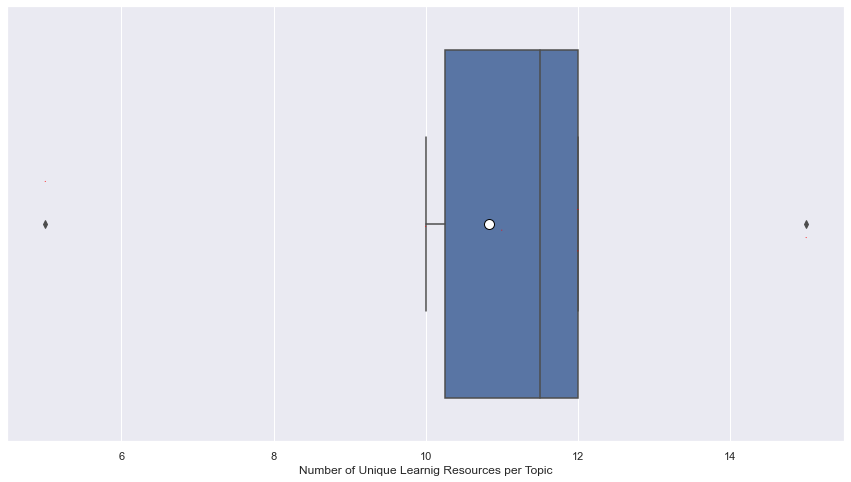

In [36]:
g = sns.boxplot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

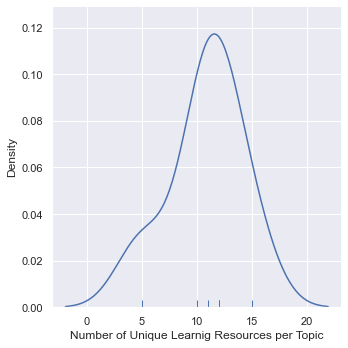

In [37]:
g = sns.displot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

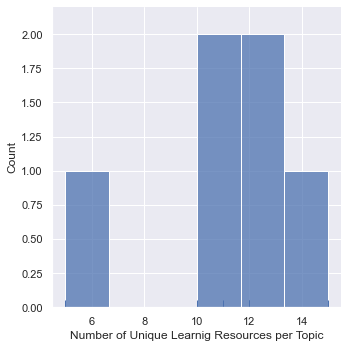

In [38]:
g = sns.displot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

### Number of Unique Users per Learning Activity

In [39]:
n_unique_users_per_learning_activity = print_and_return_unique_col2_per_col1(interactions, LEARNING_ACTIVITY_FIELD, USER_FIELD, NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR)

mean Number of Unique Users per Learnig Resource: 79.13333333333334
median Number of Unique Users per Learnig Resource: 84.0
max Number of Unique Users per Learnig Resource: 115
min Number of Unique Users per Learnig Resource: 16


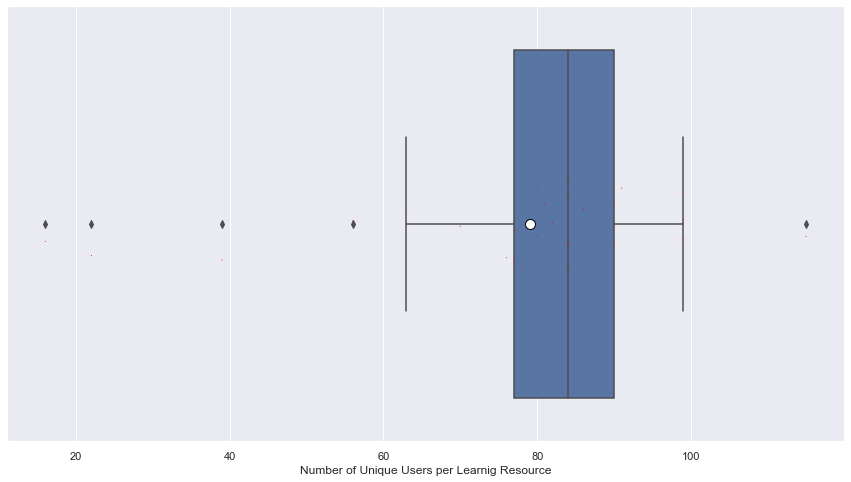

In [40]:
g = sns.boxplot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

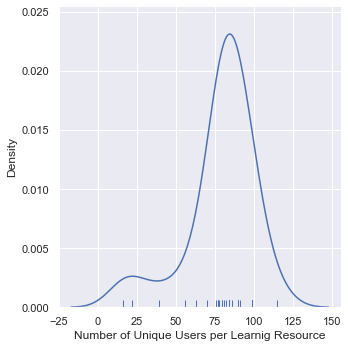

In [41]:
g = sns.displot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

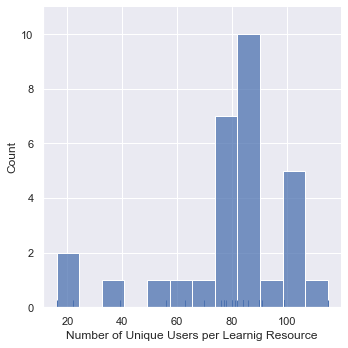

In [42]:
g = sns.displot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

### Avg Number of Interactions over Groups for a User (User Sequence Length)

In [43]:
mean_n_interactions_over_groups, median_n_interactions_over_groups = print_and_return_avg_num_interactions_over_col2_for_col1(interactions, USER_FIELD, GROUP_FIELD, MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR)

mean of Mean Number of Interactions over Topics for a User: 17.411304347826086
median of Mean Number of Interactions over Topics for a User: 15.5
max of Mean Number of Interactions over Topics for a User: 52.0
min of Mean Number of Interactions over Topics for a User: 4.75

__________________________________________________

mean of Median Number of Interactions over Topics for a User: 16.02173913043478
median of Median Number of Interactions over Topics for a User: 14.0
max of Median Number of Interactions over Topics for a User: 53.0
min of Median Number of Interactions over Topics for a User: 4.5


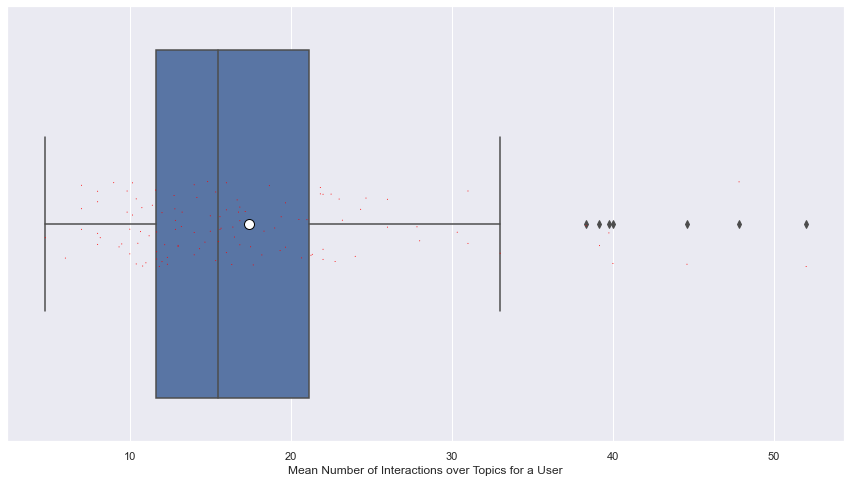

In [44]:
g = sns.boxplot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

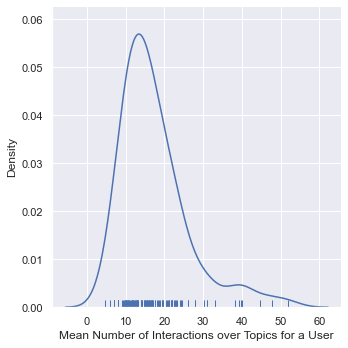

In [45]:
g = sns.displot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

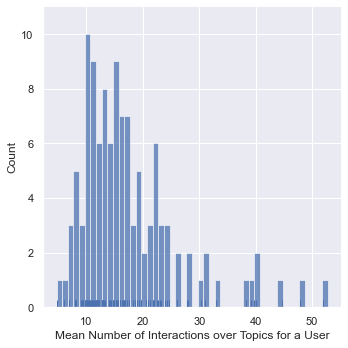

In [46]:
g = sns.displot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

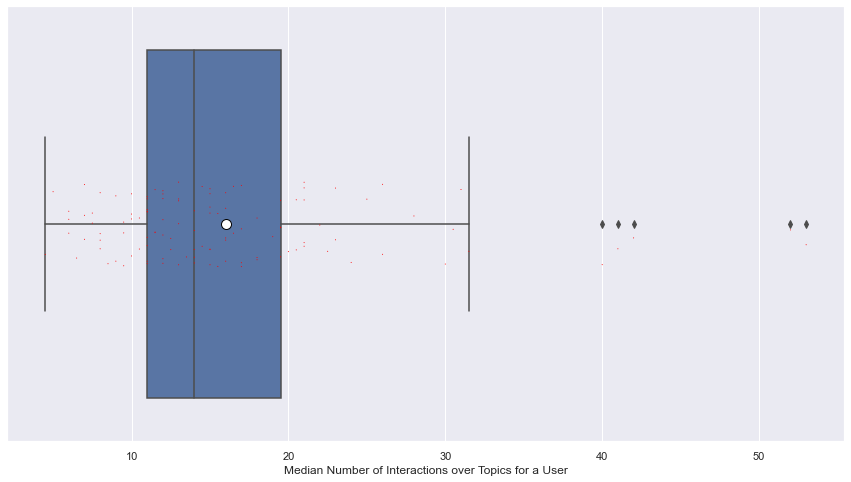

In [47]:
g = sns.boxplot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

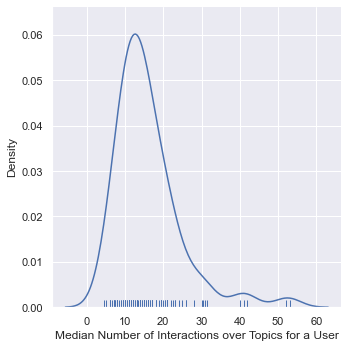

In [48]:
g = sns.displot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

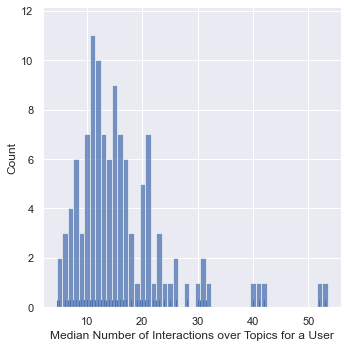

In [49]:
g = sns.displot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

### Avg Number of Interactions over Users for a Group (Group Sequence Length)

In [50]:
mean_n_interactions_over_users, median_n_interactions_over_users = print_and_return_avg_num_interactions_over_col2_for_col1(interactions, GROUP_FIELD, USER_FIELD, MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR)

mean of Mean Number of Interactions over Users for a Topic: 17.556261983196382
median of Mean Number of Interactions over Users for a Topic: 17.33372183372183
max of Mean Number of Interactions over Users for a Topic: 23.902439024390244
min of Mean Number of Interactions over Users for a Topic: 12.413793103448276

__________________________________________________

mean of Median Number of Interactions over Users for a Topic: 14.166666666666666
median of Median Number of Interactions over Users for a Topic: 14.5
max of Median Number of Interactions over Users for a Topic: 19.0
min of Median Number of Interactions over Users for a Topic: 9.0


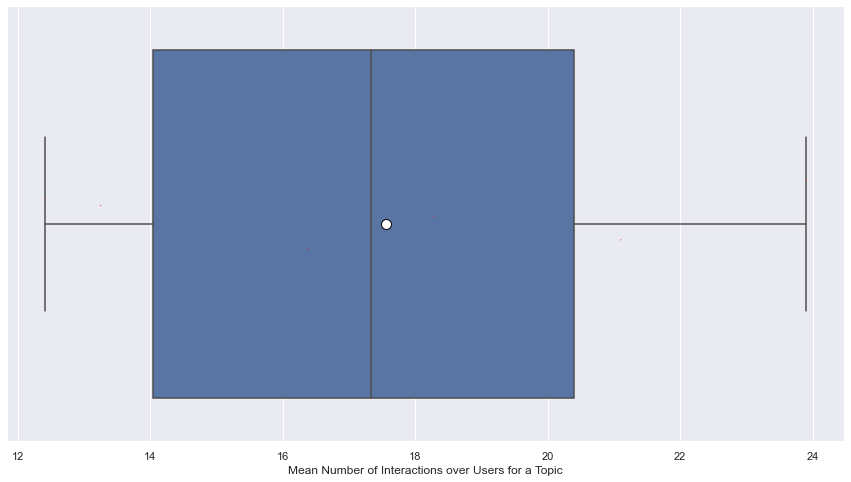

In [51]:
g = sns.boxplot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

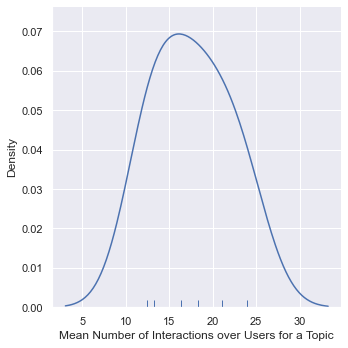

In [52]:
g = sns.displot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

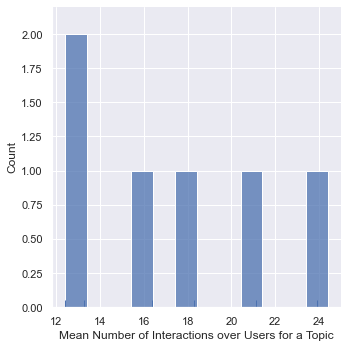

In [53]:
g = sns.displot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

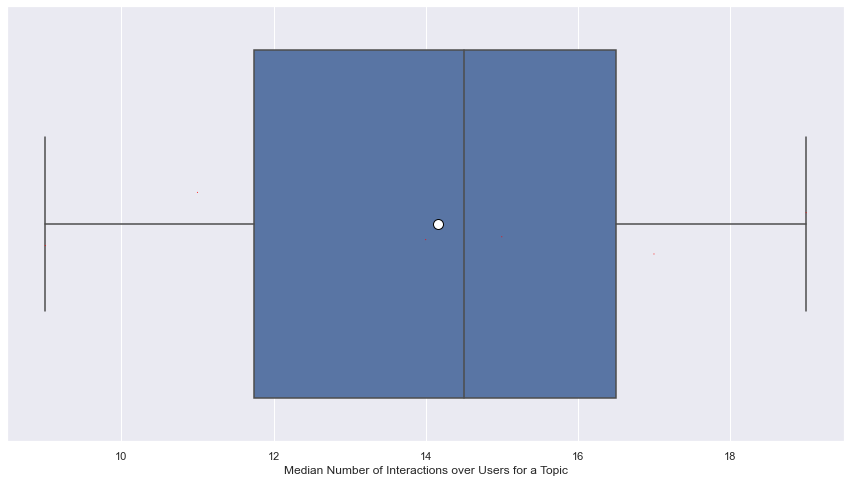

In [54]:
g = sns.boxplot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

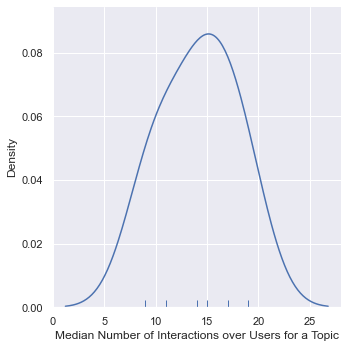

In [55]:
g = sns.displot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

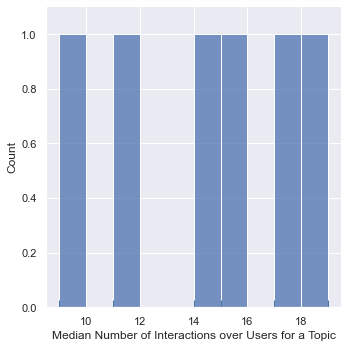

In [56]:
g = sns.displot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

### Avg Number of Unique Learning Activities over Groups for a User

In [57]:
mean_n_unique_learning_activities_over_groups_for_user, median_n_unique_learning_activities_over_groups_for_user = print_and_return_avg_num_unique_col3_over_col2_for_col1(interactions, USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR)

mean of Mean Number of Unique Learnig Resources over Topics for a User: 5.440724637681156
median of Mean Number of Unique Learnig Resources over Topics for a User: 5.5
max of Mean Number of Unique Learnig Resources over Topics for a User: 7.5
min of Mean Number of Unique Learnig Resources over Topics for a User: 3.75

__________________________________________________

mean of Median Number of Unique Learnig Resources over Topics for a User: 5.321739130434783
median of Median Number of Unique Learnig Resources over Topics for a User: 5.0
max of Median Number of Unique Learnig Resources over Topics for a User: 7.5
min of Median Number of Unique Learnig Resources over Topics for a User: 3.5


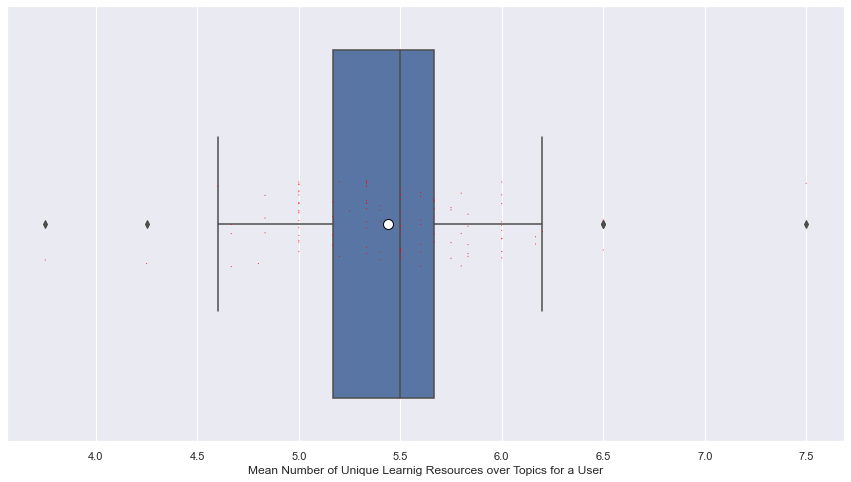

In [58]:
g = sns.boxplot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

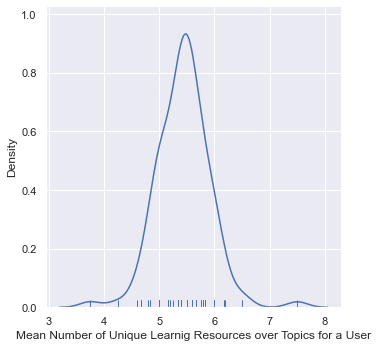

In [59]:
g = sns.displot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

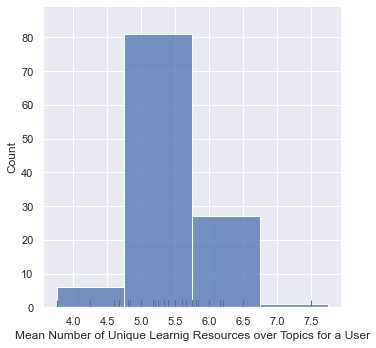

In [60]:
g = sns.displot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

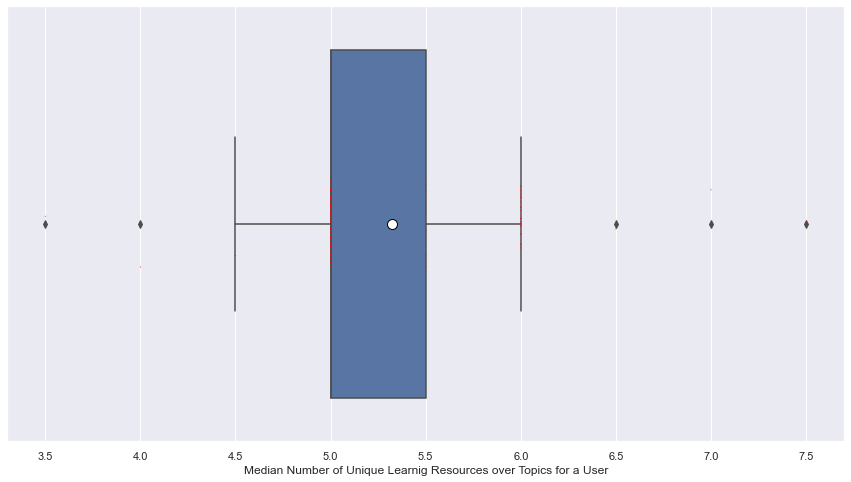

In [61]:
g = sns.boxplot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

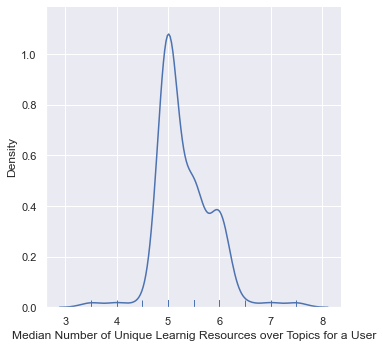

In [62]:
g = sns.displot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

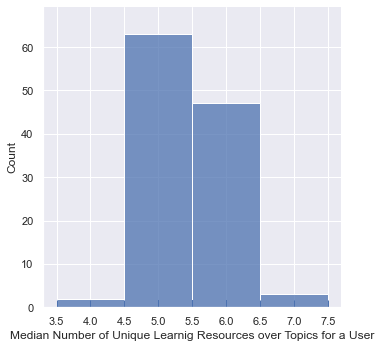

In [63]:
g = sns.displot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

### Avg Number of Unique Learning Activities over Users for a Group

In [64]:
mean_n_unique_learning_activities_over_users_for_group, median_n_unique_learning_activities_over_users_for_group = print_and_return_avg_num_unique_col3_over_col2_for_col1(interactions, GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR)

mean of Mean Number of Unique Learnig Resources over Users for a Topic: 5.423535028034608
median of Mean Number of Unique Learnig Resources over Users for a Topic: 5.037956296576986
max of Mean Number of Unique Learnig Resources over Users for a Topic: 6.512195121951219
min of Mean Number of Unique Learnig Resources over Users for a Topic: 4.928571428571429

__________________________________________________

mean of Median Number of Unique Learnig Resources over Users for a Topic: 5.5
median of Median Number of Unique Learnig Resources over Users for a Topic: 5.0
max of Median Number of Unique Learnig Resources over Users for a Topic: 7.0
min of Median Number of Unique Learnig Resources over Users for a Topic: 5.0


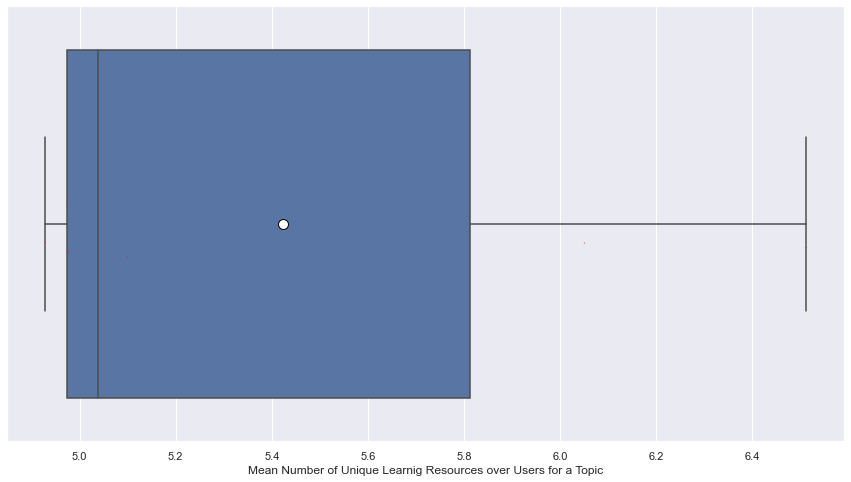

In [65]:
g = sns.boxplot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

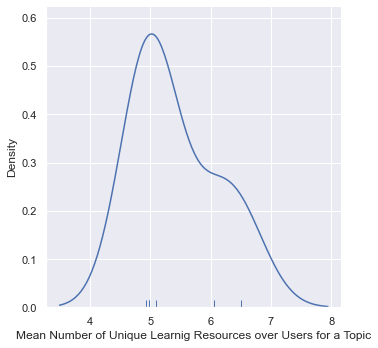

In [66]:
g = sns.displot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

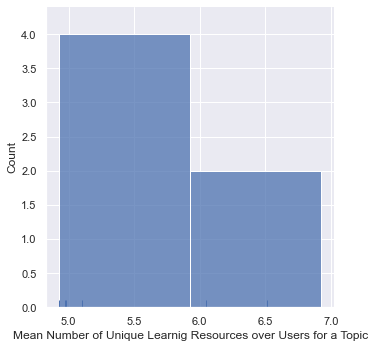

In [67]:
g = sns.displot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

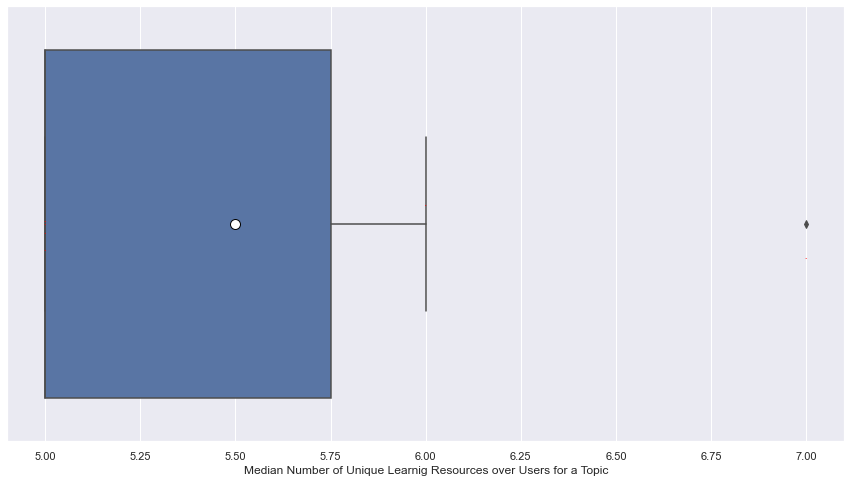

In [68]:
g = sns.boxplot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

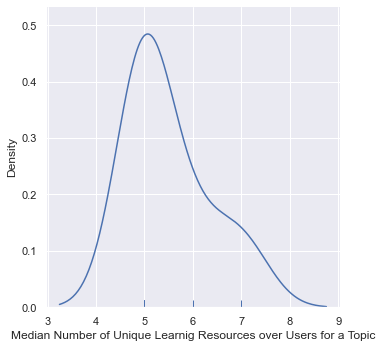

In [69]:
g = sns.displot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

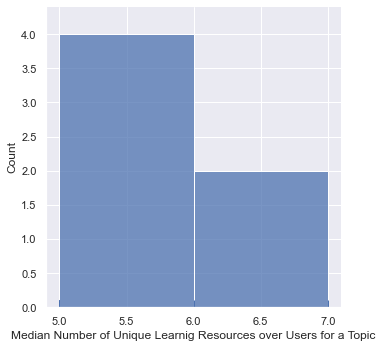

In [70]:
g = sns.displot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

### Sparsity - User_Item_Matrix

#### User-Group

In [71]:
sparsity = calculate_sparsity(interactions[USER_FIELD], interactions[GROUP_FIELD])
print(f"User-{GROUP_FIELD_NAME_STR} Sparsity: {sparsity} %")

User-Topic Sparsity: 24.637681159420282 %


#### User-Learning Activity

In [72]:
sparsity = calculate_sparsity(interactions[USER_FIELD], interactions[LEARNING_ACTIVITY_FIELD])
print(f"User-{LEARNING_ACTIVITY_FIELD_NAME_STR} Sparsity: {sparsity} %")

User-Learning Resource Sparsity: 31.188405797101453 %


## Unique Sequence Statistics

### Unique User Sequence Statistics per Group

In [ ]:
learning_activity_sequence_stats_per_group = return_col3_sequence_stats_over_col2_per_col1(interactions, 
                                                                                           GROUP_FIELD, 
                                                                                           USER_FIELD, 
                                                                                           LEARNING_ACTIVITY_FIELD,
                                                                                           TIMESTAMP_FIELD,
                                                                                           GROUP_FIELD_NAME_STR,
                                                                                           GROUP_CODE_FIELD_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                                           UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR)

In [ ]:
plot_sequence_stats_per_group(learning_activity_sequence_stats_per_group,
                              GROUP_CODE_FIELD_NAME_STR, 
                              LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                              UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PCT_PER_GROUP_TITLE_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PER_GROUP_TITLE_NAME_STR,
                              LEARNING_ACTIVITY_UNIQUE_VS_TOTAL_NUMBER_OF_SEQUENCES_PER_GROUP_TITLE_NAME_STR)

### Unique User Sequence Statistics

In [ ]:
learning_activity_sequence_stats = return_col2_sequence_stats_over_col1(interactions, 
                                                                        USER_FIELD, 
                                                                        LEARNING_ACTIVITY_FIELD,
                                                                        TIMESTAMP_FIELD,
                                                                        LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                        UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR)

In [ ]:
plot_sequence_stats(learning_activity_sequence_stats,
                    LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                    UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PCT_TITLE_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_TITLE_NAME_STR,
                    LEARNING_ACTIVITY_UNIQUE_VS_TOTAL_NUMBER_OF_SEQUENCES_TITLE_NAME_STR)

## Sequence Distance

### Sequence Distance between Users per Group

In [ ]:
seq_sim = SeqSim(interactions.head(100000), USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD)

In [ ]:
seq_dist_per_group_dict = seq_sim.get_user_sequence_distances_per_group(td.levenshtein.distance, sample_pct=80, sample_pct_user=10)

In [ ]:
with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME, 'wb') as f:
    pickle.dump(seq_dist_per_group_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
avg_seq_dist_per_group_df = get_avg_seq_dist_per_group_df(seq_dist_per_group_dict)

In [ ]:
avg_seq_dist_per_group_df

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='mean_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='mean_distance', size=5, color="red");
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_mean_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='median_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='median_distance', size=5, color="red");
g.set(xlabel=f'Median Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_median_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='mean_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='median_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Median Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', size=5, color="red");
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_mean_normalized_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', size=5, color="red");
g.set(xlabel=f'Median Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_median_normalized_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Median Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_distance', y='mean_user_sequence_length')
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', y='mean_user_sequence_length')
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_distance', y='mean_max_seq_length_per_group')
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Max Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', y='mean_max_seq_length_per_group')
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Max Sequence Length per {GROUP_FIELD_NAME_STR}');

### Sequence Distance between Users 

In [ ]:
seq_sim = SeqSim(interactions.head(50000), USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD)

In [ ]:
seq_dist_dict = seq_sim.get_user_sequence_distances(td.levenshtein.distance, sample_pct=20)

In [ ]:
with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PICKLE_NAME, "wb") as f:
    pickle.dump(seq_dist_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
seq_dist_df = get_seq_dist_df(seq_dist_dict)

In [ ]:
seq_dist_df

In [ ]:
g = sns.boxplot(data=seq_dist_df, x='distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=seq_dist_df, x='distance', size=5, color="red");
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_seq_dist_per_user_combination_pair.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=seq_dist_df, x='distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.boxplot(data=seq_dist_df, x='normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=seq_dist_df, x='normalized_distance', size=5, color="red");
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_normalized_seq_dist_per_user_combination_pair.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=seq_dist_df, x='normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='distance', y='mean_user_sequence_length_per_combination')
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Mean Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='normalized_distance', y='mean_user_sequence_length_per_combination')
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Mean Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='distance', y='max_user_sequence_length_per_combination')
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Max Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='normalized_distance', y='max_user_sequence_length_per_combination')
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Max Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');